# OpSim -- the updated simulation notebook

## About

This notebook is for testing of the OpSim functionality.
Data is read from prefabricated files containing the Sun and the two Satellites' positions as time series. The data is stored and read in the HDF5 format.

In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility ---
import os
import sys

import numpy as np
import h5py

import yaml
import matplotlib.pyplot as plt
import simpy

print("Path:")
print("-------------------------------------")
for path_part in sys.path:
    if path_part!='': print(f'''{path_part}''')


# ---
import lusee        # Core lusee software
import nav          # Astro/observation wrapper classes
from   nav import *

import sim          # Simulation handler
import hardware     # hardware modules

#from hardware.parts import *; from hardware.panels import *;from hardware.controller import *; from hardware.battery import *

# ---

print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}, sim: {sim.__version__}''')

Path:
-------------------------------------
/home/maxim/projects/lusee/opsim/notebooks
/home/maxim/projects/lusee/luseepy
/home/maxim/projects/lusee/opsim
/home/maxim/.virtualenvs/lusee/lib/python3.10/site-packages/backports
/usr/local/lib/python310.zip
/usr/local/lib/python3.10
/usr/local/lib/python3.10/lib-dynload
/home/maxim/.virtualenvs/lusee-simpy/lib/python3.10/site-packages
simpy: 4.0.2, lusee: 1.2-dev, sim: 0.1


In [2]:
orbitals    = "../data/2025-02-04_03-07.hdf5"
modes       = "../config/modes.yml"
devices     = "../config/devices.yml"

In [3]:
import sim
from sim import Simulator

smltr = Simulator(orbitals, modes, devices)

smltr.populate()

smltr.info()
mySun = smltr.sun
mySat = smltr.esa


Shape of the data payload: (3072, 7)
Created a Battery with initial charge: 100.0, capacity: 1200.0
../data/2025-02-04_03-07.hdf5
../config/modes.yml
../config/devices.yml


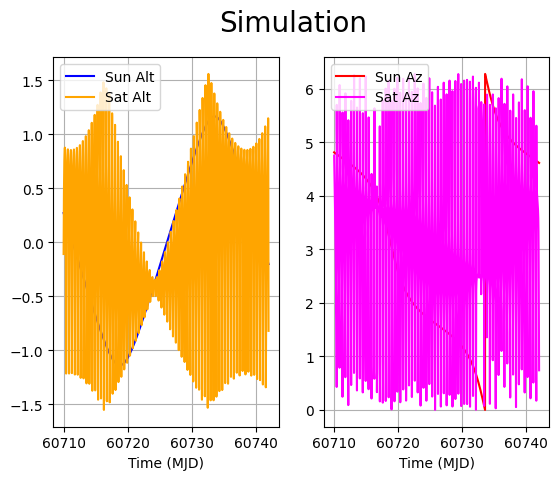

In [4]:
fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p2.set_xlabel('Time (MJD)')

p1.plot(mySun.mjd, mySun.alt,  color="blue",   label="Sun Alt")
p1.plot(mySat.mjd, mySat.alt,  color="orange", label="Sat Alt")

p2.plot(mySun.mjd, mySun.az, color="red",    label="Sun Az")
p2.plot(mySat.mjd, mySat.az, color="magenta",label="Sat Az")

p1.grid(True)
_ = p1.legend()

p2.grid(True)
_ = p2.legend()


Sunrise: 60726.145833333336


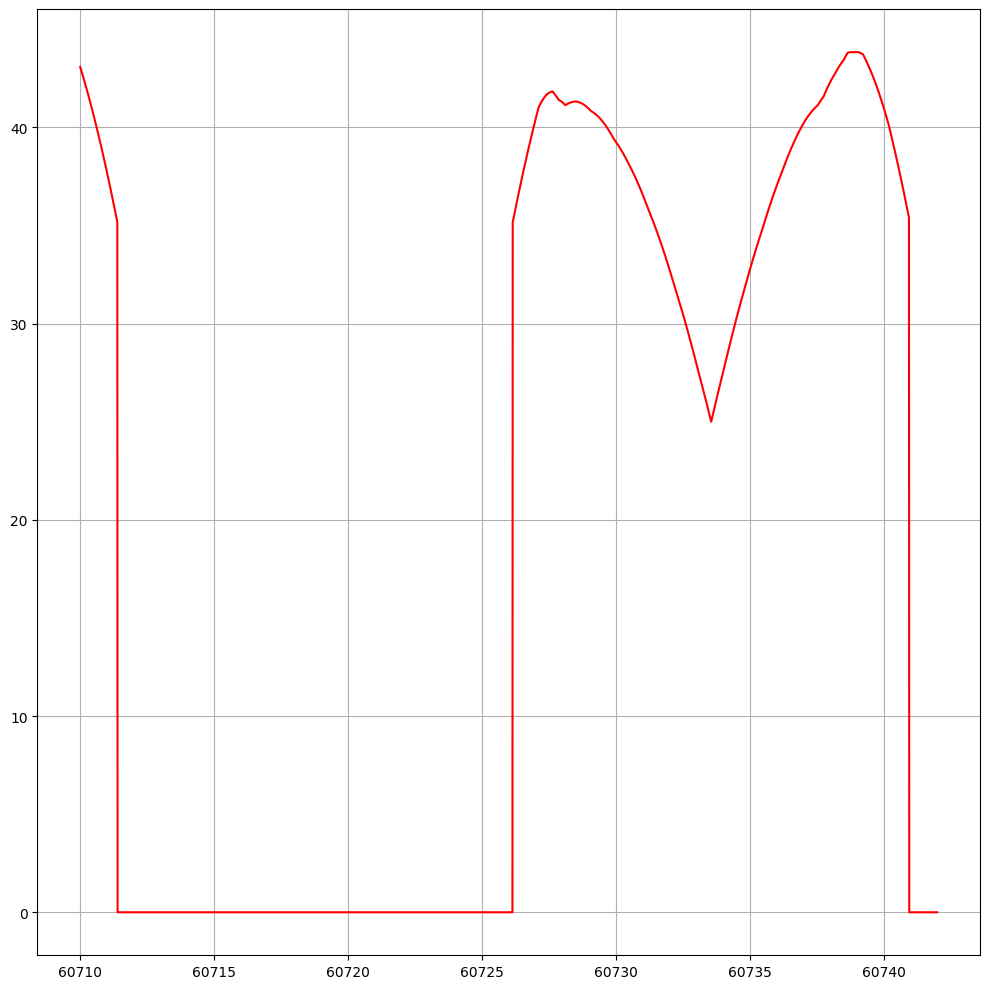

In [7]:
print(f'''Sunrise: {mySun.sunrise}''')

plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, smltr.controller.power*100.,  color="red",    label="Panel power*100")
ax.grid(True)


---

### Device properties

Device descriptions, such as states and power consumption for each state, can be stored in a _YAML_ file and read into the application.


In [9]:
# Read device configuration
import yaml

device_file = '../config/devices.yml'
print(f'''Reading device profiles from the file "{'../config/devices.yml'}"''')
f = open(device_file, 'r')

device_data = yaml.load(f, Loader=yaml.FullLoader)
profiles    = device_data['devices']
print(profiles.keys())



Reading device profiles from the file "../config/devices.yml"
dict_keys(['controller', 'comms'])


---

### Run the simulation

In [10]:
for device_name in profiles.keys():
    device = Device(device_name, profiles[device_name])
    ctr.add_device(device)

ctr.set_device_state('controller', 'ON')

print('List added devices:')
for added_device in ctr.devices.keys():
        dvc = ctr.devices[added_device]
        print(dvc.name, dvc.state)

env.process(ctr.run())
env.run(until=mySun.N)


List added devices:
controller ON
comms OFF


---

### Plot the results

In [ ]:
fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD) - daytime')
p2.set_xlabel('Time (MJD)')

p1.plot(mySun.mjd, ctr.power,  color="blue",   label="Panel exposure (area units)")
p2.plot(mySun.mjd, ctr.monitor.battery, color="red",    label="Panel power (a.u.)")


p1.set_xlim([60725,60742.5])

p1.grid(True)
p2.grid(True)

plt.show()






---

## Archived utilities

Useful bits of code that aren't necesserily executed every time.


In [ ]:
# Pretty print the dictionary we read from the input YAML, for an extra check:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [ ]:
print('Current directory:', os.getcwd())

# Define files to configure the run:

conf_flnm   = '../config/conf.yml'
modes_flnm  = '../config/modes.yml'
devices_flnm= '../config/devices.yml'


print(f'''-------------------- {conf_flnm} ---------------------------------------------------''')
conf    = yaml.safe_load(open(conf_flnm, 'r'))
pretty(conf)


print(f'''-------------------- {modes_flnm} ---------------------------------------------------''')
modes   = yaml.safe_load(open(modes_flnm, 'r'))
pretty(modes)


print(f'''-------------------- {devices_flnm} ---------------------------------------------------''')
devices   = yaml.safe_load(open(modes_flnm, 'r'))
pretty(devices)
